# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc,col,asc, when, count, isnull
import pyspark.sql.functions as F

import datetime

import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from pyspark.ml.feature import StandardScaler,IndexToString, StringIndexer, MinMaxScaler
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import Vectors 
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import Tokenizer,CountVectorizer, HashingTF, IDF, PCA 
from pyspark.ml.feature import VectorIndexer, OneHotEncoderEstimator, StopWordsRemover,VectorAssembler

from sklearn.metrics import classification_report
from sklearn import preprocessing



In [2]:
plt.rcParams['figure.figsize'] = [18, 16]

In [3]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
event_log = spark.read.json("mini_sparkify_event_data.json")

In [5]:
event_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Let's remove the fields that have information that can identify a person i.e `firstName` and `lastName`

In [6]:
event_logs = event_log.select(["artist","auth","gender","itemInSession","length","level","location","page","registration"\
                              ,"sessionId","song","ts","status","userAgent","userId"])

In [7]:
event_log.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Data Exploration

* Does gender have any influence on user churn? 
* What Platforms do users use?
* What are Top 10 locations with higher churn?
* Does subscription level have any influence on user churn?
* What are the popular hours users login to listen to music?

In [8]:
# get hour from timestamp ts field to get popular hours
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
event_logs = event_logs.withColumn("hour", get_hour(event_logs.ts))
songs_in_hour = event_logs.filter(event_logs.page == "NextSong").groupby(event_logs.hour).count()\
                .orderBy(event_logs.hour.cast("float"))

In [9]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

In [10]:
# songs_in_hour.show()

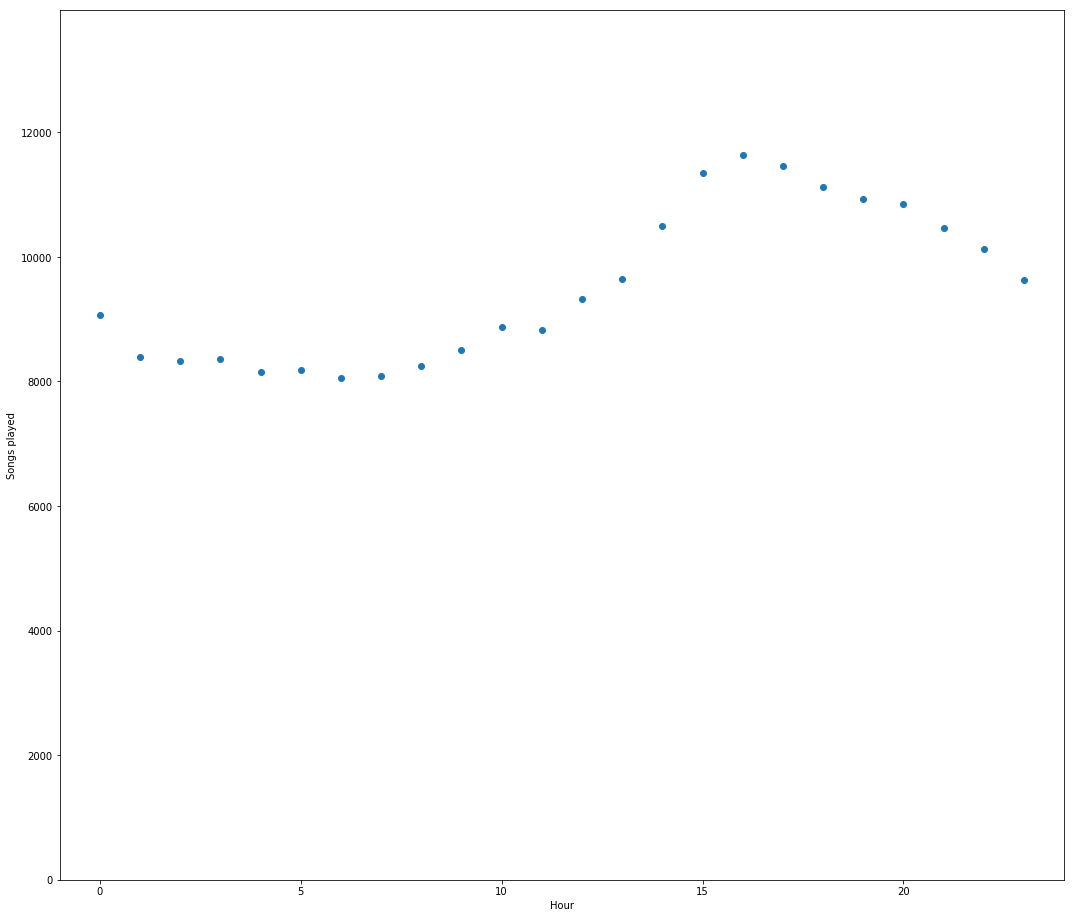

In [11]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

From the graph it looks like most hours 15-20 are very popluar for listening to music. 

Now let's create columns `downgraded` and `churn` to identify users who downgraded their service and who had to cancel their subscription based on the web pages that they visited

In [12]:
event_logs.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [13]:
flag_downgrade = udf(lambda x: 1 if x=="Submit Downgrade" else 0, IntegerType())
event_logs=event_logs.withColumn("downgraded", flag_downgrade(event_logs.page))

In [14]:
flag_churn = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0,IntegerType())
event_logs = event_logs.withColumn("churn",flag_churn(event_logs.page))

Let's do a quick sanity check on the fields that we have.

In [15]:
event_logs.filter(col("gender").isNull()).select("userId").dropDuplicates().show()

+------+
|userId|
+------+
|      |
+------+



So the records that don't have gender don't have userId as well. Let's quickly check what pages captured these events

In [16]:
event_logs.filter(col("gender").isNull()).select("page").dropDuplicates().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [17]:
event_logs.count()

286500

These are the pages that the user visited before logging into the system. Let's delete these events as they dont provide much information 

In [18]:
event_logs.filter(col("userId")=="").count()

8346

Let's remove the events that have null userId. These are mostly the events that are captured before the user logged into the service

In [19]:
event_logs=event_logs.filter(col("userId")!="")

In [20]:
# event_logs.filter(col('auth')!="Logged Out").select("userId").dropDuplicates().summary()

In [21]:
df_churn_analysis=event_logs.select("userId","gender","churn","level").dropDuplicates().toPandas()

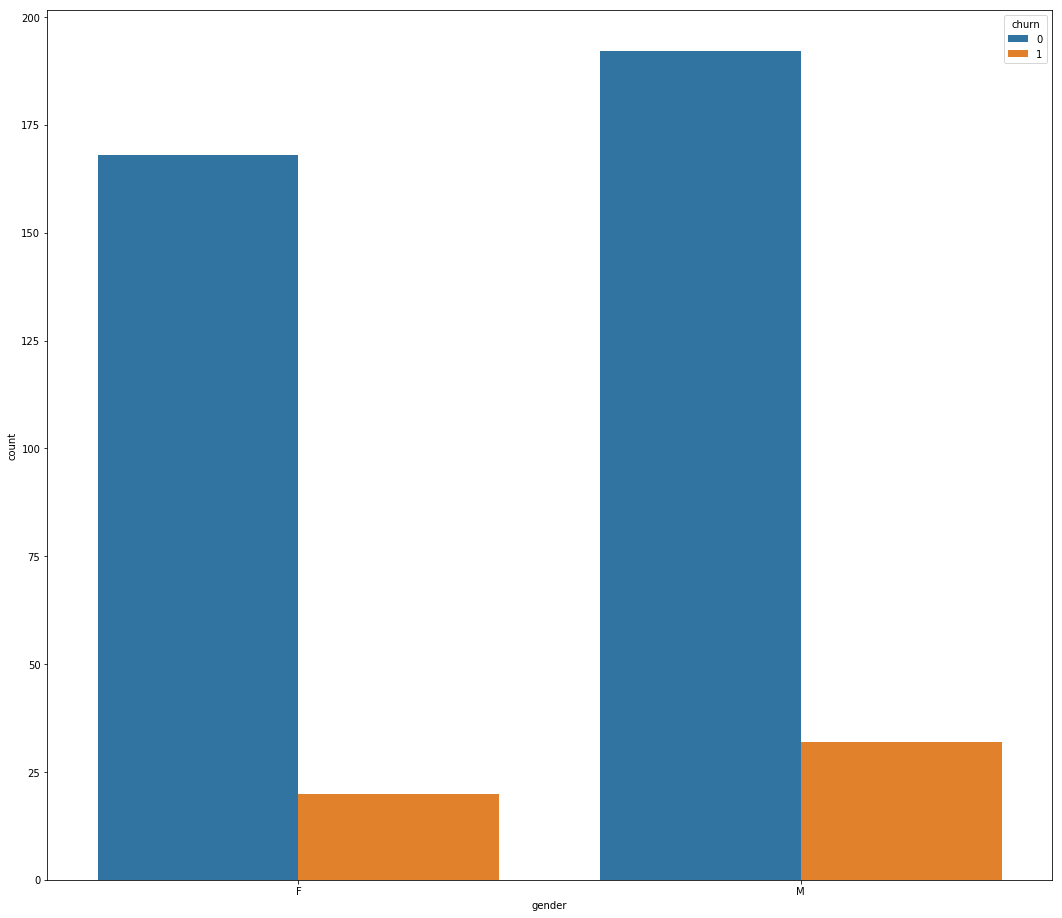

In [22]:
sns.countplot(x="gender",hue="churn",data=df_churn_analysis)

From the graph we can conclude that we have higher number of male users than the Female and the churn among male members is higher as well.

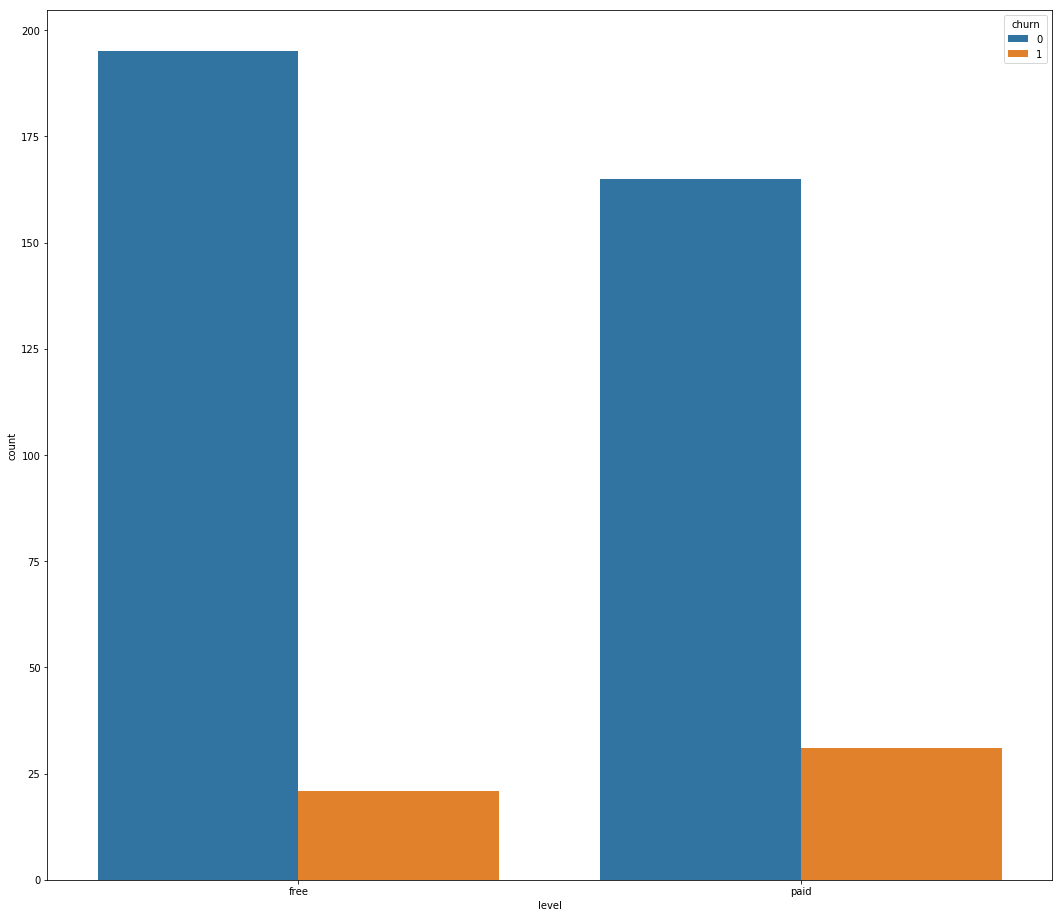

In [23]:
sns.countplot(x="level",hue="churn",data=df_churn_analysis)

We have a lot of free subscription users than the paid users. Of course not everyone wants to subscribe and spend when there is free version. Churn is higher among the paid subscribers than the free subscribers. Is it that the service is bad? Or the songs that are available on the platform?

In [24]:
event_logs.groupBy(["status","level"]).count().sort("status").show()

+------+-----+------+
|status|level| count|
+------+-----+------+
|   200| paid|203952|
|   200| free| 50766|
|   307| paid| 18282|
|   307| free|  4902|
|   404| paid|   199|
|   404| free|    53|
+------+-----+------+



From the above numbers it doesn't look like the platform/service is bad. Can it be the songs listed on the service? Wish we had some information on this regarding different types of songs listed for more analysis.

In [25]:
event_logs.groupby("level").count().sort("level").show()

+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+



We have a high number of paid subscribers than the free subscibers. Let's not go deeper into who are the paid and free subscribers rather we don't have much data to dig further as well.


Now let's check what platform are famous among the users.

In [26]:
import re
def get_platform(userAgent):
    platform_reg=re.compile(".*\((?P<platform>[A-Za-z0-9 ;:\._\/]+)\).*")
    platform = platform_reg.match(userAgent).group('platform')
    if ";" not in platform:
        platform = platform.replace("(","").replace(")","")
    elif "compatible" in platform:
        platform = platform.replace("(","").replace(")","").split(";")[2]
    elif "X11" in platform:
        platform = "Linux"
    platform = platform.split(";")[0].strip()
    if "Windows" in platform:
        platform= "Windows"
    return platform

In [27]:
platform = udf(get_platform,StringType())

In [28]:
event_logs=event_logs.withColumn("platform",platform(col('userAgent')))

In [29]:
event_logs.select("platform").dropDuplicates().sort("platform").show()

+---------+
| platform|
+---------+
|    Linux|
|Macintosh|
|  Windows|
|     iPad|
|   iPhone|
+---------+



In [30]:
platform_counts=event_logs.groupby("platform").count().sort("platform").toPandas()

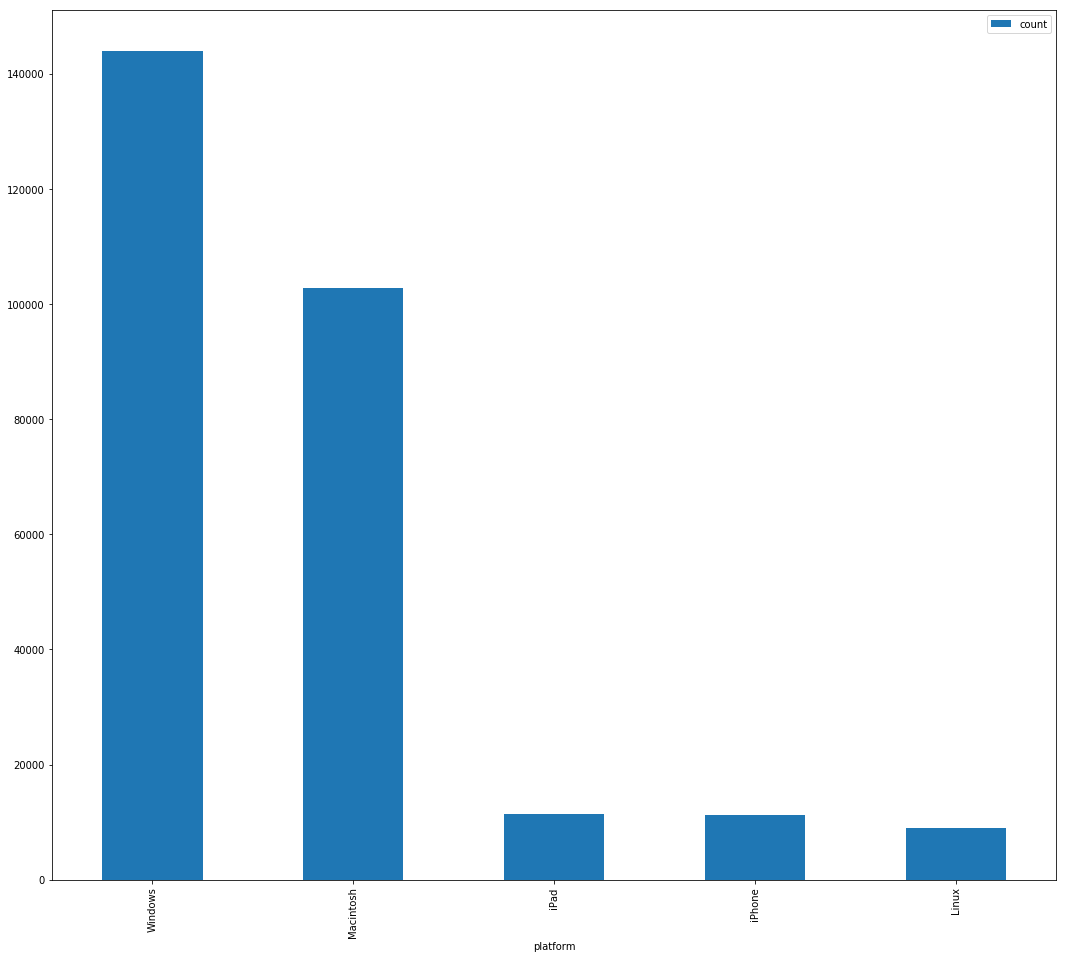

In [31]:
# sns.countplot(x="platform",data=platform_counts)
platform_counts.sort_values(by="count",ascending=False).plot.bar(x="platform",y="count")

`Windows` is a popular platforms that users access the service from followed my `Macintish` and `iPads`

In [32]:
location_churn=event_logs.filter(col("churn")==1).groupby("location","churn").count().sort("location").toPandas()

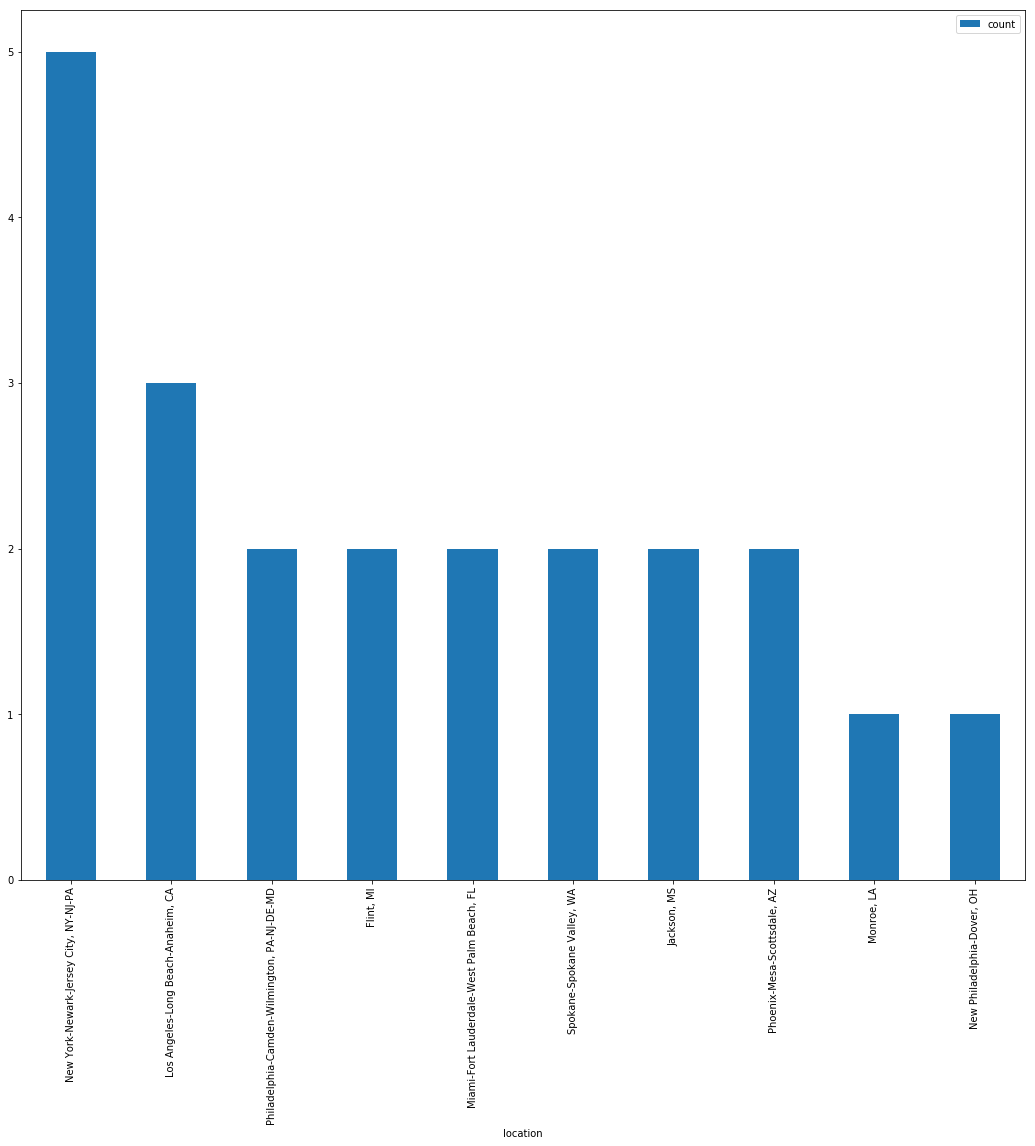

In [33]:
location_churn.sort_values(by="count",ascending=False).head(10).plot.bar(x="location",y="count")

From the top 10 locations for higher number of churns, we have `NYC` leading the table followed by `LA` and `Philadelphia` regions.

In [34]:
# event_logs.filter(col('churn')==1).take(2)

In [35]:
# page_analysis.sort_values(by="page")

In [36]:
# sns.countplot(x="count",hue="churn",data=page_analysis)
# plt.xticks(rotation=90)
# plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Let's use the following features for the model

* Average Session length
* Number of Platforms used by the user
* Number of artists
* Number of Thumbs Up
* NUmber of Thumbs Down
* Number of Sessions
* Number of days since registration
* Gender
* Platform
* Level of subscription
* Churn (label)
* Downgraded

In [37]:
df_feature_set1 = event_logs.groupBy("userId").agg(F.avg("length").alias("avg_session_length"),F.countDistinct(col('platform')).alias("number_of_platforms"),\
                                 F.max(col('ts')).alias("last_used"), F.min(col('registration')).alias("registration"),\
                                F.countDistinct(col('artist')).alias("number_of_artists"),F.countDistinct(col("sessionId")).alias("number_of_sessions"),\
                                )

In [38]:
def num_active_days(reg,last_used):
    """
    This function is used to get the total number of active days
    input: registration datetime and last used datetime
    output: Days active
    """
    return (datetime.datetime.fromtimestamp(last_used/1000) - datetime.datetime.fromtimestamp(reg/1000)).days

In [39]:
active_days = udf(num_active_days,IntegerType())

In [40]:
df_feature_set1=df_feature_set1.withColumn('active_days',active_days(col('registration'),col('last_used')))

In [41]:
#Number of Thumbs down
thumbs_down_df=event_logs.filter(col('page')=='Thumbs Down').groupBy("userId").count().withColumnRenamed('count',"thumbs_down")

In [42]:
#Number of Thumbs up
thunmbs_up_df = event_logs.filter(col('page')=='Thumbs Up').groupBy("userId").count().withColumnRenamed('count',"thumbs_up")

In [43]:
downgraded_df = event_logs.filter(col('downgraded')==1).select('userId','downgraded').dropDuplicates()

In [44]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "userIdTemp")
    df = df1.join(df2, df1.userId == df2.userIdTemp, "left").drop("userIdTemp")
    return df

In [45]:
df = features_merge(df_feature_set1,thumbs_down_df)

In [46]:
df = features_merge(df,thunmbs_up_df)
df = features_merge(df,downgraded_df)


In [47]:
churn_users=event_logs.filter(col('churn')==1).select('userId','churn')

In [48]:
df = features_merge(df,churn_users)


In [49]:
df=df.fillna({'churn':0,'thumbs_up':0,'thumbs_down':0,'downgraded':0})

In [50]:
cat_features_df = event_logs.select("gender","userId","location","platform","level").dropDuplicates()
df = features_merge(df,cat_features_df)


In [51]:
df.take(5)

[Row(userId='100010', avg_session_length=243.4214449090909, number_of_platforms=1, last_used=1542823952000, registration=1538016340000, number_of_artists=252, number_of_sessions=7, active_days=55, thumbs_down=5, thumbs_up=17, downgraded=0, churn=0, gender='F', location='Bridgeport-Stamford-Norwalk, CT', platform='iPhone', level='free'),
 Row(userId='200002', avg_session_length=242.91699209302325, number_of_platforms=1, last_used=1542324354000, registration=1536269906000, number_of_artists=339, number_of_sessions=6, active_days=70, thumbs_down=6, thumbs_up=21, downgraded=0, churn=0, gender='M', location='Chicago-Naperville-Elgin, IL-IN-WI', platform='iPhone', level='free'),
 Row(userId='200002', avg_session_length=242.91699209302325, number_of_platforms=1, last_used=1542324354000, registration=1536269906000, number_of_artists=339, number_of_sessions=6, active_days=70, thumbs_down=6, thumbs_up=21, downgraded=0, churn=0, gender='M', location='Chicago-Naperville-Elgin, IL-IN-WI', platform=

In [52]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+------------------+-------------------+---------+------------+-----------------+------------------+-----------+-----------+---------+----------+-----+------+--------+--------+-----+
|userId|avg_session_length|number_of_platforms|last_used|registration|number_of_artists|number_of_sessions|active_days|thumbs_down|thumbs_up|downgraded|churn|gender|location|platform|level|
+------+------------------+-------------------+---------+------------+-----------------+------------------+-----------+-----------+---------+----------+-----+------+--------+--------+-----+
|     0|                 0|                  0|        0|           0|                0|                 0|          0|          0|        0|         0|    0|     0|       0|       0|    0|
+------+------------------+-------------------+---------+------------+-----------------+------------------+-----------+-----------+---------+----------+-----+------+--------+--------+-----+



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [53]:
#split dataset into training and test
training_df, test_df = df.randomSplit([0.7, 0.3])
training_df.cache()

DataFrame[userId: string, avg_session_length: double, number_of_platforms: bigint, last_used: bigint, registration: bigint, number_of_artists: bigint, number_of_sessions: bigint, active_days: int, thumbs_down: bigint, thumbs_up: bigint, downgraded: int, churn: int, gender: string, location: string, platform: string, level: string]

Let's get the pipeline created accordingly for both numeric and categorical features

In [54]:
#numeric columns
numeric_columns = ['avg_session_length','number_of_platforms',\
                   'number_of_artists','number_of_sessions','active_days','thumbs_down','thumbs_up']
categorical_columns = ['gender','platform','level','downgraded']

stages = []

for col in categorical_columns:
    stringIndexer = StringIndexer(inputCol = col, outputCol = col + '_index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "_vec"])
    stages += [stringIndexer, encoder]
    
##numbers
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="numeric_assemble")
scaler = StandardScaler(inputCol="numeric_assemble", outputCol="std_numeric")
pca = PCA(inputCol="std_numeric", outputCol="PCA_numeric")
stages += [assembler,scaler,pca]

##label
label_index = StringIndexer(inputCol = 'churn', outputCol = 'label')
stages += [label_index]

##assembler, features
assemblerInputs =  [cat + "_vec" for cat in categorical_columns]+ ["PCA_numeric"]
assembler2 = VectorAssembler(inputCols=assemblerInputs,outputCol="features") 
stages += [assembler2]

# Logistic Regression

In [55]:
##LR model
lr = LogisticRegression(maxIter=20,family="binomial")

##LR params
param_grid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 0.8]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .addGrid(pca.k,[6,7])\
    .build()



lr_crossval = CrossValidator(estimator=Pipeline(stages=stages+[lr]),\
                          estimatorParamMaps=param_grid,\
                          numFolds=3,\
                          evaluator=BinaryClassificationEvaluator(),\
                            parallelism=5)


In [56]:
lr_model = lr_crossval.fit(training_df)

In [57]:
best_lr_model = lr_model.bestModel
best_lr_model.save('./LR_Model')
lr_results = lr_model.transform(test_df)

Let's adjust the thresholds to maximise F1 score for the model and save the final model

In [58]:
training_summary = best_lr_model.stages[-1].summary
print("areaUnderROC: " + str(training_summary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = training_summary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
best_threshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

print("Best threshold: ", best_threshold)

areaUnderROC: 0.8135365853658535
Best threshold:  0.37145595376409635


In [59]:
best_lr_model.stages[-1]._java_obj.setThreshold(best_threshold)
best_lr_model.save('./LR_with_threshold')

In [60]:
lr_thresh_model = best_lr_model.transform(test_df)

In [61]:
labels_lr = list(lr_thresh_model.select('label').toPandas()['label'])
pred = list(lr_thresh_model.select('prediction').toPandas()['prediction'])
print(classification_report(labels_lr,pred,target_names=['No Churn', 'Churn']))

              precision    recall  f1-score   support

    No Churn       0.86      0.89      0.87        73
       Churn       0.58      0.50      0.54        22

   micro avg       0.80      0.80      0.80        95
   macro avg       0.72      0.70      0.70        95
weighted avg       0.79      0.80      0.79        95



Logistic Regression scores a 79% based on F1 score for the features we have. Not bad for the mini dataset that we used.

In [62]:
print(best_lr_model.stages[-4]._java_obj.extractParamMap())
print(best_lr_model.stages[-1]._java_obj.extractParamMap())

{
	PCA_2f7637efeeb5-inputCol: std_numeric,
	PCA_2f7637efeeb5-k: 7,
	PCA_2f7637efeeb5-outputCol: PCA_numeric
}
{
	LogisticRegression_f31b7d61ff57-aggregationDepth: 2,
	LogisticRegression_f31b7d61ff57-elasticNetParam: 0.8,
	LogisticRegression_f31b7d61ff57-family: binomial,
	LogisticRegression_f31b7d61ff57-featuresCol: features,
	LogisticRegression_f31b7d61ff57-fitIntercept: true,
	LogisticRegression_f31b7d61ff57-labelCol: label,
	LogisticRegression_f31b7d61ff57-maxIter: 20,
	LogisticRegression_f31b7d61ff57-predictionCol: prediction,
	LogisticRegression_f31b7d61ff57-probabilityCol: probability,
	LogisticRegression_f31b7d61ff57-rawPredictionCol: rawPrediction,
	LogisticRegression_f31b7d61ff57-regParam: 0.0,
	LogisticRegression_f31b7d61ff57-standardization: true,
	LogisticRegression_f31b7d61ff57-threshold: 0.37145595376409635,
	LogisticRegression_f31b7d61ff57-tol: 1.0E-6
}


So, PCA has value of K set to 7 so that ir maximises the variance for the features and L2 or the regularisation parameter set to 0.0

# Gradient Boosting Tree

In [63]:
##model
gbt = GBTClassifier()

##params

param_grid_gbt = ParamGridBuilder() \
    .addGrid(pca.k,[6,7])\
    .addGrid(gbt.maxIter,[3,5,10, 20])\
    .addGrid(gbt.maxDepth,[2, 4, 8])\
    .build()



gbt_cross_val = CrossValidator(estimator=Pipeline(stages=stages+[gbt]),\
                          estimatorParamMaps=param_grid_gbt,\
                          numFolds=3,\
                          evaluator=BinaryClassificationEvaluator())

gbt_model = gbt_cross_val.fit(training_df)
best_gbt_model = gbt_model.bestModel
best_gbt_model.save('./GBT_Model')

In [64]:
gbt_results = gbt_model.transform(test_df)

In [65]:
labels_gbt = list(gbt_results.select('label').toPandas()['label'])
pred_gbt = list(gbt_results.select('prediction').toPandas()['prediction'])
print(classification_report(labels_gbt,pred_gbt,target_names=['No Churn', 'Churn']))

              precision    recall  f1-score   support

    No Churn       0.88      0.95      0.91        73
       Churn       0.76      0.59      0.67        22

   micro avg       0.86      0.86      0.86        95
   macro avg       0.82      0.77      0.79        95
weighted avg       0.86      0.86      0.86        95



# Random Forest Classifier

In [67]:
rf = RandomForestClassifier()

##params
param_grid_rf = ParamGridBuilder() \
    .addGrid(pca.k,[6,7]) \
    .addGrid(rf.numTrees,[1,2,4,8,16]) \
    .addGrid(rf.maxDepth,[2,4,8,16]) \
    .build()


rf_cross_val = CrossValidator(estimator=Pipeline(stages=stages+[rf]),\
                      estimatorParamMaps=param_grid_rf,\
                      numFolds=5,\
                      evaluator=MulticlassClassificationEvaluator())
rf_model = rf_cross_val.fit(training_df)
best_rf_model = rf_model.bestModel
best_rf_model.save('./RF_Model')
rf_results = rf_model.transform(test_df)

In [68]:
labels_rf = list(rf_results.select('label').toPandas()['label'])
pred_rf = list(rf_results.select('prediction').toPandas()['prediction'])
print(classification_report(labels_rf,pred_rf,target_names=['No Churn', 'Churn']))

              precision    recall  f1-score   support

    No Churn       0.89      0.89      0.89        73
       Churn       0.64      0.64      0.64        22

   micro avg       0.83      0.83      0.83        95
   macro avg       0.76      0.76      0.76        95
weighted avg       0.83      0.83      0.83        95



From the above 2 models we can see that GBT and RandomForest Classifier outperform Logistic Regression model in terms of the overall F1 score and GBT is the best among out of the 3 models tested.

# Conclusion

## Data Exploration

From the `mini_sparkify_event_data.json` dataset we can conclude that

* Churn among male members is higher, along with the number of male popluation being higher than that of female population
* Churn is higher among the paid subscribers than the free subscribers as expected
* Windowas, Macintosh and Ipads are the most populat platforms that users use to access the service
* Most users are active from hours 15-20 i.e mostly in the late afternoons to early nights
* Top 10 locations for higher number of churns, we have NYC leading the table followed by LA and Philadelphia regions.


## Feature Engineering

We extracted the following features from the data as a part of Feature Engineering process

* Average Session length
* Number of Platforms used by the user
* Number of artists
* Number of Thumbs Up
* NUmber of Thumbs Down
* Number of Sessions
* Number of days since registration
* Gender
* Platform
* Level of subscription
* Downgraded
* Churn (label)

## Modeling

We tried 3 different models namely

* Logistic Regression
* Gradient Boosting Trees
* Random Forest Classifier

Out of the above models that were tried GBT performs the best, followed by RFC and LR models with 86%, 83% and 79% F1 scores respectively.

## Next steps

We can try to optimize the models and try out new models like Neural Networks, Support Vector Machines and see how a non-linear classifier might perform on the given dataset and try to add in more features based on error pages etc..

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
%%bash
tar -czf archive.tar.gz foldername